# Kvíz játék Jupyter Notebook

In [ ]:
import random
import logging
import database as db
import tkinter as tk
from tkinter import ttk
import tkinter.font as font
import tkinter.messagebox as msg
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from textwrap import wrap

In [ ]:
# Player object
class Player:
    def __init__(self, player_name) -> None:
        # Get player data if possible
        player = db.execute_query(
            f"SELECT * FROM kviz_app_players WHERE name='{player_name}'"
        )

        # If there is no player named "player_name", then create it
        if player == None:
            db.execute_query(
                f"INSERT INTO kviz_app_players (name) VALUES ('{player_name}')"
            )
            player = db.execute_query(
                f"SELECT * FROM kviz_app_players WHERE name='{player_name}'"
            )

        # Initialize player default values
        self.id = player[0]
        self.name = player[1]
        self.score_total = player[2]
        self.score_current = 0
        self.correct_answers = 0
        self.wrong_answers = 0
        self.answered = 0
        logging.debug("Initialized Player object: %s", vars(self))

    # Reset player statistics
    def reset_stats(self) -> None:
        self.score_current = 0
        self.correct_answers = 0
        self.wrong_answers = 0
        self.answered = 0
        logging.debug("Player stats reset")

In [ ]:
# Game object
class Game:
    def __init__(self) -> None:
        # Set up default window display
        window_width = 800
        window_height = 450
        window_font = "Fixedsys"
        self.window_theme_color = "lightblue"

        logging.info(f"Window size: {window_width}x{window_height} px")
        logging.info(f"Window theme color: {self.window_theme_color}")
        logging.info(f"Window font style: {window_font}")

        self.root = tk.Tk()
        self.root.title("Kvíz játék")
        self.root.geometry(f"{window_width}x{window_height}")
        self.root.resizable(False, False)
        self.root.configure(bg=self.window_theme_color)

        # Set up menu bar
        menubar = tk.Menu(self.root)
        file_menu = tk.Menu(menubar, tearoff=0)
        file_menu.add_command(
            label="Játék statisztika", command=self.popup_game_statistics
        )
        file_menu.add_separator()
        file_menu.add_command(label="Kilépés", command=self.root.quit)
        menubar.add_cascade(label="Menü", menu=file_menu)
        helpmenu = tk.Menu(menubar, tearoff=0)
        helpmenu.add_command(label="Segítség", command=self.popup_help)
        helpmenu.add_command(label="Névjegy", command=self.popup_about)
        menubar.add_cascade(label="Segítség", menu=helpmenu)
        self.root.config(menu=menubar)

        # Set default fonts
        self.titleFont = font.Font(family=window_font, size=40, weight="bold")
        self.altTitleFont = font.Font(family=window_font, size=16, weight="bold")
        self.questionFont = font.Font(family=window_font, size=20, weight="bold")
        self.commonFont = font.Font(family=window_font, size=14)
        self.miscFont = font.Font(family="Arial", size=14)
        self.statsFont = font.Font(family="Arial", size=10)

        # Set up main menu frame
        self.main_menu_frame = tk.Frame(self.root)
        self.main_menu_frame.configure(bg=self.window_theme_color)
        self.main_menu_frame.pack()
        self.player_name_entry = tk.StringVar()

        # Create empty questions array
        self.quiz_questions = []

        # Pack GUI elements
        ttk.Label(
            self.main_menu_frame,
            text="Kvíz játék",
            font=self.titleFont,
            background=self.window_theme_color,
        ).pack(pady=20)
        ttk.Label(
            self.main_menu_frame,
            text="Kérlek add meg a neved:",
            font=self.commonFont,
            background=self.window_theme_color,
        ).pack()
        ttk.Entry(
            self.main_menu_frame,
            width=20,
            textvariable=self.player_name_entry,
            justify="center",
            font=self.commonFont,
            background=self.window_theme_color,
        ).pack(pady=10)
        ttk.Button(
            self.main_menu_frame,
            width=40,
            text="Új játék kezdése",
            command=self.load_player,
        ).pack(pady=10)

        # Create top list section
        toplist = self.get_toplist()
        ttk.Label(
            self.main_menu_frame,
            text="Toplista:",
            font=self.altTitleFont,
            background=self.window_theme_color,
        ).pack(pady=20)
        player_count = 0

        for player_data in toplist:
            if player_data[1] > 0:
                ttk.Label(
                    self.main_menu_frame,
                    text=f"{player_count+1}.\t{player_data[0]}\t\t{player_data[1]}",
                    font=self.commonFont,
                    background=self.window_theme_color,
                ).pack()
                player_count += 1

        for i in range(5 - player_count):
            ttk.Label(
                self.main_menu_frame,
                text=f"{player_count+i+1}.\t-\t\t-",
                font=self.commonFont,
                background=self.window_theme_color,
            ).pack()

        # TKinter main loop
        self.root.mainloop()

    # Fetch top players from database
    def get_toplist(self) -> list:
        return db.execute_query(
            f"SELECT name, score FROM kviz_app_players ORDER BY kviz_app_players.score DESC LIMIT 5",
            True,
        )

    # Load player and start initializing the game
    def load_player(self) -> None:
        player_name = self.player_name_entry.get()
        if len(player_name) > 0:
            self.main_menu_frame.destroy()
            player = Player(player_name)
            self.init_game(player)
        else:
            msg.showwarning(
                "Figyelmeztetés", "Kérlek írd le a játékos nevedet a megfelelő mezőbe"
            )

    # Initialize the game
    def init_game(self, player) -> None:
        logging.info("New round started...")
        player.reset_stats()
        self.generate_questions()
        self.play_game(player)

    # Generate questions list
    def generate_questions(self) -> list:
        questions = db.execute_query(f"SELECT * FROM kviz_app_questions", True)

        # Shuffle the questions to randomize order
        random.shuffle(questions)

        for question in questions:
            answers = db.execute_query(
                f"SELECT * FROM kviz_app_answers WHERE question_id={question[0]}", True
            )
            # Shuffle the answers to randomize order
            random.shuffle(answers)

            # Populate the quiz question list
            self.quiz_questions.append(
                {
                    "question_id": question[0],
                    "question_text": question[1],
                    "correct_answer": question[2],
                    "answers": answers,
                }
            )

    # Clear the frame, remove widgets from it
    def clear_frame(self, frame) -> None:
        for widget in frame.winfo_children():
            widget.destroy()
            frame.pack_forget()

    # Start the quiz game
    def play_game(self, player) -> None:
        # Create the frame
        playing_frame = tk.Frame(self.root)
        playing_frame.configure(bg=self.window_theme_color)
        playing_frame.pack()

        if len(self.quiz_questions) > 0:
            quiz_task = self.quiz_questions[0]
            question_text = "\n".join(wrap(quiz_task["question_text"], 40))
            logging.info("New question appeared.")
            # Pack GUI elements
            ttk.Label(
                playing_frame,
                font=self.commonFont,
                text=f"{player.name}, jelenleg {player.score_total} pontod van. Sok sikert kívánok!",
                anchor="center",
                background=self.window_theme_color,
            ).pack(pady=10)
            ttk.Label(
                playing_frame,
                font=self.altTitleFont,
                text="Kérdés:",
                anchor="center",
                background=self.window_theme_color,
            ).pack(pady=5)
            ttk.Label(
                playing_frame,
                font=self.questionFont,
                text=question_text,
                anchor="center",
                background=self.window_theme_color,
            ).pack(pady=5)
            ttk.Label(
                playing_frame,
                font=self.commonFont,
                text="Kattints a helyes válaszra:",
                anchor="center",
                background=self.window_theme_color,
            ).pack(pady=20)
            ttk.Button(
                playing_frame,
                width=40,
                text=quiz_task["answers"][0][1],
                command=lambda: self.check_answer(
                    quiz_task["answers"][0][0],
                    playing_frame,
                    player,
                    quiz_task["question_id"],
                    quiz_task["answers"],
                ),
            ).pack(ipadx=30, ipady=5)
            ttk.Button(
                playing_frame,
                width=40,
                text=quiz_task["answers"][1][1],
                command=lambda: self.check_answer(
                    quiz_task["answers"][1][0],
                    playing_frame,
                    player,
                    quiz_task["question_id"],
                    quiz_task["answers"],
                ),
            ).pack(ipadx=30, ipady=5)
            ttk.Button(
                playing_frame,
                width=40,
                text=quiz_task["answers"][2][1],
                command=lambda: self.check_answer(
                    quiz_task["answers"][2][0],
                    playing_frame,
                    player,
                    quiz_task["question_id"],
                    quiz_task["answers"],
                ),
            ).pack(ipadx=30, ipady=5)
            ttk.Button(
                playing_frame,
                width=40,
                text=quiz_task["answers"][3][1],
                command=lambda: self.check_answer(
                    quiz_task["answers"][3][0],
                    playing_frame,
                    player,
                    quiz_task["question_id"],
                    quiz_task["answers"],
                ),
            ).pack(ipadx=30, ipady=5)
            ttk.Button(
                playing_frame,
                width=40,
                text="Válaszadók statisztikája a kérdésről",
                command=lambda: self.popup_question_statistics(quiz_task),
            ).pack(ipadx=30, ipady=5, pady=20)
        else:
            logging.info("Quiz has ended.")
            # Pack GUI elements
            ttk.Label(
                playing_frame,
                font=self.titleFont,
                text="A kvíz véget ért!",
                anchor="center",
                background=self.window_theme_color,
            ).pack(pady=20)
            ttk.Label(
                playing_frame,
                font=self.altTitleFont,
                text="Eredmény:",
                anchor="center",
                background=self.window_theme_color,
            ).pack(pady=5)
            ttk.Label(
                playing_frame,
                font=self.commonFont,
                text=f"Összesen {player.answered} választ adtál.",
                anchor="center",
                background=self.window_theme_color,
            ).pack(pady=5)
            ttk.Label(
                playing_frame,
                font=self.commonFont,
                text=f"A kvíz során {player.score_current} pontot gyűjtöttél és összesen {player.score_total} pontod van.",
                anchor="center",
                background=self.window_theme_color,
            ).pack(pady=5)
            ttk.Label(
                playing_frame,
                font=self.commonFont,
                text=f"Helyes válaszok száma: {player.correct_answers}",
                anchor="center",
                background=self.window_theme_color,
            ).pack(pady=5)
            ttk.Label(
                playing_frame,
                font=self.commonFont,
                text=f"Helytelen válaszok száma: {player.wrong_answers}",
                anchor="center",
                background=self.window_theme_color,
            ).pack(pady=5)
            ttk.Button(
                playing_frame,
                width=40,
                text="Új játék indítása",
                command=lambda: [
                    self.clear_frame(playing_frame),
                    self.init_game(player),
                ],
            ).pack(pady=10)
            ttk.Button(
                playing_frame,
                width=40,
                text="Kilépés a játékból",
                command=self.root.destroy,
            ).pack(pady=10)

    # Display the current question's statistics
    def popup_question_statistics(self, quiz_task) -> None:
        # Fetch the statistics for the current question
        answer_statistics = db.execute_query(
            f"SELECT answered_1, answered_2, answered_3, answered_4 FROM question_statistics WHERE question_id={quiz_task['question_id']}"
        )

        if answer_statistics:
            # Get the current question's answers
            answers = db.execute_query(
                f"SELECT answer FROM kviz_app_answers WHERE question_id={quiz_task['question_id']}",
                True,
            )

            # Build the data for plot
            max_value = max(answer_statistics)
            index_value_of_max = [
                index
                for index in range(len(answer_statistics))
                if answer_statistics[index] == max_value
            ]
            pie_explode = [0.0, 0.0, 0.0, 0.0]
            pie_labels = [answers[0][0], answers[1][0], answers[2][0], answers[3][0]]

            for index in index_value_of_max:
                pie_explode[index] = 0.1

            # Create the plot
            plt.title(f"Válaszadók statisztikája:\n{quiz_task['question_text']}")
            plt.pie(
                np.array(answer_statistics),
                labels=pie_labels,
                explode=pie_explode,
                startangle=90.0,
                autopct="%1.1f%%",
            )
            plt.show()
        else:
            msg.showwarning("Figyelmeztetés", "Nincs statisztikai adat a kimutatásra")

    # Display game statistics
    def popup_game_statistics(self) -> None:
        # Fetch player count
        player_count = db.execute_query("SELECT COUNT(*) FROM kviz_app_players")

        if player_count:
            player_count = player_count[0]
        else:
            player_count = 0

        # Fetch answers count
        sum_answers = db.execute_query(
            "SELECT SUM(correct_answers), SUM(wrong_answers) FROM kviz_app_playerstatistics"
        )

        if sum_answers[0] and sum_answers[1]:
            sum_correct_answers = sum_answers[0]
            sum_wrong_answers = sum_answers[1]
        else:
            sum_correct_answers = 0
            sum_wrong_answers = 0

        # Set up frame and pack elements
        top = tk.Toplevel(self.root)
        top.geometry("250x180")
        top.resizable(False, False)
        top.title("Játék statisztika")
        ttk.Label(top, text="Játék statisztika", font=self.miscFont).pack(
            padx=10, pady=10, anchor="w"
        )
        ttk.Label(
            top, text=f"Összes játékosok száma: {player_count}", font=self.statsFont
        ).pack(padx=10, anchor="w")
        ttk.Label(
            top,
            text=f"Összes válaszok száma: {sum_correct_answers+sum_wrong_answers}",
            font=self.statsFont,
        ).pack(padx=10, anchor="w")
        ttk.Label(
            top,
            text=f"Összes helyes válaszok száma: {sum_correct_answers}",
            font=self.statsFont,
        ).pack(padx=10, anchor="w")
        ttk.Label(
            top,
            text=f"Összes helytelen válaszok száma: {sum_wrong_answers}",
            font=self.statsFont,
        ).pack(padx=10, anchor="w")
        ttk.Button(
            top,
            width=20,
            text="Kérdések statisztikája",
            command=self.popup_all_questions_statistics,
        ).pack(padx=10, pady=10, anchor="w")

        # Force focus when window displayed
        top.focus_force()

    # Display every questions's statistics
    def popup_all_questions_statistics(self) -> None:
        # Fetch questions
        all_questions = db.execute_query(
            "SELECT question_id, correct_answers, wrong_answers FROM question_statistics ORDER BY correct_answers asc",
            True,
        )

        if all_questions:
            barh_labels = []
            barh_correct_values = []
            barh_wrong_values = []

            for question_correct_stat in all_questions:
                question_name = db.execute_query(
                    f"SELECT question FROM kviz_app_questions WHERE id={question_correct_stat[0]}"
                )
                if question_name:
                    barh_labels.append(question_name[0])
                    barh_correct_values.append(question_correct_stat[1])
                    barh_wrong_values.append(question_correct_stat[2])

            # If question is too long, then wrap it
            barh_labels = ["\n".join(wrap(l, 40)) for l in barh_labels]

            # Set up Dataframe
            df = pd.DataFrame(
                {
                    "Helyes válaszok": barh_correct_values,
                    "Helytelen válaszok": barh_wrong_values,
                },
                index=barh_labels,
            )

            # Set up plot
            ax = df.plot.barh()
            plt.subplots_adjust(left=0.2)
            plt.xlabel("Válaszok száma", horizontalalignment="right", x=1.0)
            plt.ylabel("Kérdések", horizontalalignment="right", y=1.0)
            plt.title("A kérdések válaszainak aránya")
            mng = plt.get_current_fig_manager()
            mng.window.state("zoomed")
            plt.grid(axis="x")
            plt.show()
        else:
            msg.showwarning("Figyelmeztetés", "Nincs statisztikai adat a kimutatásra")

    # Check player's answer
    def check_answer(
        self, answer, playing_frame, player, question_id, quiz_answers
    ) -> None:
        if answer == self.quiz_questions[0]["correct_answer"]:
            logging.info("Player answer was correct.")
            player.score_current += 100
            player.score_total += 100
            player.correct_answers += 1
            player.answered += 1
            self.update_player_score(player.id, player.score_total)
            self.add_player_statistics(player, "correct_answers")
            self.add_question_statistics(
                question_id, "correct_answers", quiz_answers, answer
            )
        else:
            logging.info("Player answer was wrong.")
            player.wrong_answers += 1
            player.answered += 1
            self.add_player_statistics(player, "wrong_answers")
            self.add_question_statistics(
                question_id, "wrong_answers", quiz_answers, answer
            )
        self.quiz_questions.pop(0)
        playing_frame.destroy()
        self.play_game(player)

    # Upload player statistics into database
    def add_player_statistics(self, player, outcome) -> None:
        stat_row_id = db.execute_query(
            f"SELECT id FROM kviz_app_playerstatistics WHERE player_id={player.id}"
        )
        if stat_row_id:
            logging.debug("Updating player statistics...")
            db.execute_query(
                f"UPDATE kviz_app_playerstatistics SET {outcome}={outcome}+1 WHERE id={stat_row_id[0]}"
            )
        else:
            logging.debug("Player statistics are not exists... creating one.")
            db.execute_query(
                f"INSERT INTO kviz_app_playerstatistics (player_id, {outcome}) VALUES ('{player.id}', '1')"
            )

    # Upload question statistics into database
    def add_question_statistics(
        self, question_id, outcome, quiz_answers, answer
    ) -> None:
        # Sort is needed to save answer count correctly
        quiz_answers.sort()

        for i, quiz_answer in enumerate(quiz_answers):
            if quiz_answer[0] == answer:
                answer_number = i + 1

        question_stat_row_id = db.execute_query(
            f"SELECT id FROM question_statistics WHERE question_id={question_id}"
        )

        if question_stat_row_id:
            logging.debug("Updating question statistics...")
            db.execute_query(
                f"UPDATE question_statistics SET {outcome}={outcome}+1, answered_{answer_number}=answered_{answer_number}+1 WHERE id={question_stat_row_id[0]}"
            )
        else:
            logging.debug("Question statistics are not exists... creating one.")
            db.execute_query(
                f"INSERT INTO question_statistics (question_id, {outcome}, answered_{answer_number}) VALUES ('{question_id}', '1', '1')"
            )

    # Update player score
    def update_player_score(self, player_id, score) -> None:
        logging.debug("Updating player score -> %d", score)
        db.execute_query(
            f"UPDATE kviz_app_players SET score='{score}' WHERE id={player_id}"
        )

    # Display "About" window
    def popup_about(self) -> None:
        top = tk.Toplevel(self.root)
        top.geometry("600x300")
        top.resizable(False, False)
        top.title("Kvíz játék - Névjegy")
        tk.Label(
            top,
            text="🐸🐸🐸\n\nA programot készítette Gyetvai Tamás\n\nEz egy vizsgafeladat megoldása, amely a 2023-ban induló Webuni Python középhaladó tanfolyamhoz készült.\n\n\n\nKöszönöm, hogy kipróbáltad a kvíz játékomat!\n\n🍄🍄🍄",
            justify="center",
            font=self.miscFont,
            wraplength=500,
        ).pack()
        top.focus_force()

    # Display "Help" window
    def popup_help(self) -> None:
        top = tk.Toplevel(self.root)
        top.geometry("500x320")
        top.resizable(False, False)
        top.title("Kvíz játék - Segítség")
        tk.Label(
            top,
            text="🦊🌿🌎💫🍉🍽⛷\n\nA kvíz játék célja, hogy a kapott kérdésre helyes választ adjunk.\n\nA kvíz kezdéséhez add meg játékos nevedet. A kvíz kérdései után minden helyes válaszért 100 pontot kapsz, amit folyamatosan növelhetsz újabb próbálkozások során.\nAz 5 legjobban teljesítő játékos felkerül a kvíz toplistára.\n\nSok sikert a feladatok megoldásához!\n\n💰🔑🔮🧩🥇💯💲🕹",
            justify="center",
            font=self.miscFont,
            wraplength=500,
        ).place(x=0, y=10)
        top.focus_force()

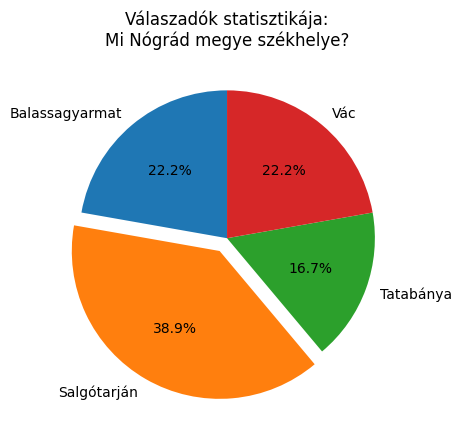

In [23]:
logging.info("Quiz game has started.")

# Start quiz game
game = Game()